In [299]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Dataset loading

In [300]:
df = pd.read_csv('video_games.csv')
df.head()

,id,name,category,n_dlcs,n_expansions,year,follows,in_franchise,genres,companies,platforms,user_score,user_rating,n_user_reviews,summary
0,1020,Grand Theft Auto V,main_game,0,0,2013,1766,True,"Shooter, Adventure","Rockstar North, Rockstar Games, Take-Two Inter...","PC (Microsoft Windows), PlayStation 3, Xbox 36...",90.202388,great,3369,Grand Theft Auto V is a vast open world game s...
1,1942,The Witcher 3: Wild Hunt,main_game,4,2,2015,1516,True,"Role-playing (RPG), Adventure","WB Games, Bandai Namco Entertainment, cdp.pl, ...","PC (Microsoft Windows), PlayStation 4, Xbox On...",95.169577,great,2997,"RPG and sequel to The Witcher 2 (2011), The Wi..."
2,472,The Elder Scrolls V: Skyrim,main_game,3,0,2011,1046,False,"Role-playing (RPG), Adventure","Bethesda Game Studios, Bethesda Softworks","PC (Microsoft Windows), PlayStation 3, Xbox 360",87.508504,great,2567,Skyrim reimagines and revolutionizes the open-...
3,72,Portal 2,main_game,3,0,2011,963,True,"Shooter, Platform, Puzzle, Adventure","Valve Corporation, Electronic Arts","Linux, PC (Microsoft Windows), PlayStation 3, ...",91.650705,great,2544,"Sequel to the acclaimed Portal (2007), Portal ..."
4,71,Portal,main_game,0,0,2007,894,True,"Shooter, Platform, Puzzle","Valve Corporation, EA","Linux, PC (Microsoft Windows), PlayStation 3, ...",86.931758,great,2297,"Waking up in a seemingly empty laboratory, the..."


In [301]:
original_n_rows = len(df)

## Pre-processing

### Removing lines with NA values

In [302]:
perc = (df.isna().sum(axis=1) > 0).sum() / len(df)
perc *= 100
print(f'Percentage of rows with null values: {perc:.2f}%')

Percentage of rows with null values: 1.22%


Since the amount of rows with null values is small, the complete removal of those was considered statistically irrelevant.

In [303]:
df = df.dropna()

### Limiting dataset to main games

In [304]:
perc = len(df[df['category'] == 'main_game']) / len(df)
perc *= 100
print(f'Proportion of main games in the dataset: {perc:.2f}%')

Proportion of main games in the dataset: 85.71%


It was decided to only keep the main games in the dataset, as the homogeneity in the data would help in the classification goal.

In [305]:
df = df[df['category'] == 'main_game']
df = df.drop(labels=['category'], axis=1)

## EDA

Atribute correlation heatmap

[Text(0.5, 1.0, 'Correlation between the numeric attributes in the dataset')]

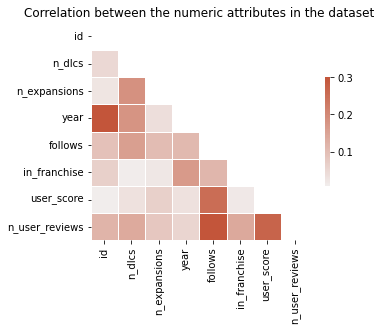

In [306]:
# It was decided to apply the absolute function to the correlation as it makes interpreting the graph easier
corr = abs(df.corr())
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}
).set(title='Correlation between the numeric attributes in the dataset')

In [307]:
aux_df = pd.DataFrame(df['user_rating'].value_counts())
aux_df = aux_df.reindex(['mediocre', 'bad', 'good', 'great']).reset_index()

px.bar(aux_df, x='index', y='user_rating',
        title='Distribution of the different user ratings',
        labels={
            'user_rating': 'Amount',
            'index': 'user_rating',
})

There is a clear imbalance in the user rating distribution

In [308]:
px.histogram(df, x='user_score', nbins=20,
            title='User score distribution',
            labels={
                'count': 'Amount'
})

In [309]:
plot_df = pd.DataFrame(df['in_franchise'].value_counts()).reset_index()
plot_df = plot_df.reindex(index=plot_df.index[::-1])

px.bar(plot_df, x='index', y='in_franchise',
        title='In franchise distribution',
        labels={
            'index': 'in_franchise',
            'in_franchise': 'Amount'
},)

Genres

In [310]:
genres_dict = dict()
for row in df['genres']:
    for g in row.replace(' ', '').split(','):
        if g in genres_dict.keys():
            genres_dict[g] += 1
        else:
            genres_dict[g] = 1

genres_df = pd.DataFrame({'genre': genres_dict.keys(), 'count': genres_dict.values()})
genres_df = genres_df.sort_values('count')
px.bar(genres_df, x='genre', y='count',
        title='Distribution of the different genres',
        labels={
            'count': 'Amount',
},)

In [311]:
px.box(genres_df, y='count', title='Boxplot of the genre appearence count distribution',
       labels={'count': 'Amount'})

In [312]:
genre_rating_dict = dict()
for g in set(genres_dict.keys()):
    genre_rating_dict[g] = dict()
    for r in ['mediocre', 'bad', 'good', 'great']:
        genre_rating_dict[g][r] = 0

for row_genre, rating in zip(df['genres'], df['user_rating']):
    for g in row_genre.replace(' ', '').split(','):
        genre_rating_dict[g][rating] += 1

plot_df_rows = []
n_genres = 12
iterable = reversed(sorted(genre_rating_dict.items(), key=lambda x: sum(x[1].values()), reverse=True)[:n_genres])
for genre, ratings_dict in iterable:
    for rating, count in ratings_dict.items():
        plot_df_rows.append({'genre': genre, 'rating': rating, 'count': count})

plot_df = pd.DataFrame(plot_df_rows)

fig = px.bar(plot_df, x='genre', y='count', color='rating', barmode='group', log_y=True,
             title='User score distribution of the different genres (log y scale)',
        labels={
            'genre': 'Genre',
            'count': 'Amount',
            'rating': 'user_rating',
        },
)
fig.show()

Companies

In [313]:
companies_dict = dict()
for row in df['companies']:
    for c in row.replace(' ', '').split(','):
        if c in companies_dict.keys():
            companies_dict[c] += 1
        else:
            companies_dict[c] = 1

companies_df = pd.DataFrame({'company': companies_dict.keys(), 'count': companies_dict.values()})
companies_df = companies_df.sort_values('count')
px.bar(companies_df[companies_df['count'] >= 20], x='company', y='count',
       title='Distribution of the different companies<br>that appear more than 20 times in the dataset',
        labels={'count': 'Amount'}
)

In [314]:
px.box(companies_df, y='count', log_y=True, 
       title='Boxplot of the company appearence count distribution', labels={'count': 'Amount'})

In [315]:
company_noise = ['Inc.', 'Ltd.', 'Inc.(SCEI)']

In [316]:
company_rating_dict = dict()
for c in set(companies_dict.keys()):
    if c not in company_noise:
        company_rating_dict[c] = dict()
        for r in ['mediocre', 'bad', 'good', 'great']:
            company_rating_dict[c][r] = 0

for row_companies, rating in zip(df['companies'], df['user_rating']):
    for c in row_companies.replace(' ', '').split(','):
        if c not in company_noise:
            company_rating_dict[c][rating] += 1

plot_df_rows = []
n_companies = 8
iterable = reversed(sorted(company_rating_dict.items(), key=lambda x: sum(x[1].values()), reverse=True)[:n_companies])
for company, ratings_dict in iterable:
    for rating, count in ratings_dict.items():
        plot_df_rows.append({'company': company, 'rating': rating, 'count': count})

plot_df = pd.DataFrame(plot_df_rows)

fig = px.bar(plot_df, x='company', y='count', color='rating', barmode='group', log_y=True,
             title='User rating distribution through the different game companies (log y scale)',
            labels={
                'count': 'Amount',
                'rating': 'user_rating',
            },       
)
fig.show()

Platform

In [317]:
platform_dict = dict()
for row in df['platforms']:
    for p in row.replace(' ', '').split(','):
        if p in platform_dict.keys():
            platform_dict[p] += 1
        else:
            platform_dict[p] = 1

platform_df = pd.DataFrame({'platform': platform_dict.keys(), 'count': platform_dict.values()})
platform_df = platform_df.sort_values('count')
px.bar(platform_df[platform_df['count'] >= 100], x='platform', y='count',
       title='Distribution of the diferent platforms<br>that appear more than 100 times in the dataset',
       labels={'count': 'Amount'}
)

It was then decided to limit the dataset to the main consoles from Sony, Microsoft and Nintendo since the Nintendo64 era, plus the PC ones, as it helps keeping the homogeinity aforementioned.

In [318]:
def to_keep(platform):
    return platform == 'PC(MicrosoftWindows)' \
        or platform.lower() == 'nintendogamecube' \
        or platform.lower() == 'nintendo64' \
        or platform.lower() == 'nintendoswitch' \
        or platform.lower() in (['playstation'] + [f'playstation{i}' for i in range(2, 6)]) \
        or 'xbox' in platform.lower() \
        or 'wii' in platform.lower() \
        
platforms_to_keep = [p for p in platform_dict.keys() if to_keep(p)]
sorted(platforms_to_keep)

['Nintendo64',
 'NintendoGameCube',
 'NintendoSwitch',
 'PC(MicrosoftWindows)',
 'PlayStation',
 'PlayStation2',
 'PlayStation3',
 'PlayStation4',
 'PlayStation5',
 'Wii',
 'WiiU',
 'Xbox',
 'Xbox360',
 'XboxOne',
 'XboxSeriesX|S']

In [319]:
platform_rating_dict = dict()
for p in set(platform_dict.keys()):
    platform_rating_dict[p] = dict()
    for r in ['mediocre', 'bad', 'good', 'great']:
        platform_rating_dict[p][r] = 0

for row_platform, rating in zip(df['platforms'], df['user_rating']):
    for p in row_platform.replace(' ', '').split(','):
        platform_rating_dict[p][rating] += 1
        
plot_df_rows = []
items = [(key, value) for key, value in platform_rating_dict.items() if key in platforms_to_keep]
iterable = sorted(items, key=lambda x: sum(x[1].values()))
for platform, ratings_dict in iterable:
    for rating, count in ratings_dict.items():
        plot_df_rows.append({'platform': platform, 'rating': rating, 'count': count})

plot_df = pd.DataFrame(plot_df_rows)

fig = px.bar(plot_df, x='platform', y='count', color='rating', barmode='group', log_y=True,
             title='User rating distribution over the different platforms (log y scale)',
            labels={
                'count': 'Amount',
                'rating': 'user_rating',
            }, 
)

fig.show()

## Feature engineering

The following topic will be bulding a treated dataset based on the information gathered in the EDA process.

The attributes decided to be kept bellow were chosen based on a combination of an analysis on the correlation matrix and intuition.

In [320]:
cols_to_keep = ['n_dlcs', 'n_expansions', 'follows', 'n_user_reviews', 'user_rating']
new_df = df[cols_to_keep]

It was decided to do a one hot encoding of the different genres, but only of those that appear 196 times and over in the dataset, as this presented a step big enough in the graph to be a good choice.

In [321]:
genres = [k for k, v in genres_dict.items() if v >= 196]
new_cols = dict()
for g in genres:
    new_cols[f'genre_{g}'] = []
new_cols['genre_other'] = []

for row in df['genres']:
    genres_in_row = row.replace(' ', '').split(',')
    found = False
    for g in genres:
        value = g in genres_in_row
        if value:
            found = True
        new_cols[f'genre_{g}'].append(value)
    new_cols['genre_other'].append(not found)

for g in genres:
    new_df.loc[:, f'genre_{g}'] = new_cols[f'genre_{g}']

/home/matheus/.miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/matheus/.miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In a similar fashion to the genre one hot encoding, the cutout was chosen as appearing 138 times and over.

In [322]:
companies = [k for k, v in companies_dict.items() if v >= 138]
new_cols = dict()
for c in companies:
    new_cols[f'company_{c}'] = []
new_cols['company_other'] = []

for row in df['companies']:
    companies_in_row = row.replace(' ', '').split(',')
    found = False
    for c in companies:
        value = c in companies_in_row
        if value:
            found = True
        new_cols[f'company_{c}'].append(value)
    new_cols['company_other'].append(not found)

for c in companies:
    new_df.loc[:, f'company_{c}'] = new_cols[f'company_{c}']

The one hot encoding was also applied to the platforms previously selected.

In [323]:
def to_keep(platform):
    return platform == 'PC(MicrosoftWindows)' \
        or platform.lower() == 'nintendogamecube' \
        or platform.lower() == 'nintendo64' \
        or platform.lower() == 'nintendoswitch' \
        or platform.lower() in (['playstation'] + [f'playstation{i}' for i in range(2, 6)]) \
        or 'xbox' in platform.lower() \
        or 'wii' in platform.lower() \
        
platforms_to_keep = [p for p in platform_dict.keys() if to_keep(p)]
sorted(platforms_to_keep)

['Nintendo64',
 'NintendoGameCube',
 'NintendoSwitch',
 'PC(MicrosoftWindows)',
 'PlayStation',
 'PlayStation2',
 'PlayStation3',
 'PlayStation4',
 'PlayStation5',
 'Wii',
 'WiiU',
 'Xbox',
 'Xbox360',
 'XboxOne',
 'XboxSeriesX|S']

In [324]:
new_cols = dict()
for p in platforms_to_keep:
    new_cols[f'platform_{p}'] = []
new_cols['platform_other'] = []

for row in df['platforms']:
    platforms_in_row = row.replace(' ', '').split(',')
    found = False
    for p in platforms_to_keep:
        value = p in platforms_to_keep
        if value:
            found = True
        new_cols[f'platform_{p}'].append(value)
    new_cols['platform_other'].append(not found)

for p in platforms_to_keep:
    new_df.loc[:, f'platform_{p}'] = new_cols[f'platform_{p}']

Resulting dataset information:

In [325]:
new_df

,n_dlcs,n_expansions,follows,n_user_reviews,user_rating,genre_Shooter,genre_Adventure,genre_Role-playing(RPG),genre_Platform,genre_Puzzle,...,platform_PlayStation5,platform_XboxSeriesX|S,platform_NintendoSwitch,platform_PlayStation2,platform_Xbox,platform_WiiU,platform_Nintendo64,platform_Wii,platform_NintendoGameCube,platform_PlayStation
0,0,0,1766,3369,great,True,True,False,False,False,...,True,True,True,True,True,True,True,True,True,True
1,4,2,1516,2997,great,False,True,True,False,False,...,True,True,True,True,True,True,True,True,True,True
2,3,0,1046,2567,great,False,True,True,False,False,...,True,True,True,True,True,True,True,True,True,True
3,3,0,963,2544,great,True,True,False,True,True,...,True,True,True,True,True,True,True,True,True,True
4,0,0,894,2297,great,True,False,False,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5816,1,0,3,11,great,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
5817,0,0,6,11,great,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
5818,0,0,6,11,great,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
5819,0,0,5,11,great,False,False,True,False,False,...,True,True,True,True,True,True,True,True,True,True


In [326]:
new_df.columns

Index(['n_dlcs', 'n_expansions', 'follows', 'n_user_reviews', 'user_rating',
       'genre_Shooter', 'genre_Adventure', 'genre_Role-playing(RPG)',
       'genre_Platform', 'genre_Puzzle', 'genre_Racing', 'genre_Simulator',
       'genre_Hackandslash/Beat'emup', 'genre_Arcade', 'genre_Point-and-click',
       'genre_Turn-basedstrategy(TBS)', 'genre_Indie', 'genre_Strategy',
       'genre_RealTimeStrategy(RTS)', 'genre_Fighting', 'genre_Tactical',
       'genre_Sport', 'company_ElectronicArts',
       'company_SonyComputerEntertainment', 'company_Inc.(SCEI)',
       'company_UbisoftEntertainment', 'company_SquareEnix',
       'company_Nintendo', 'company_Activision', 'company_Capcom',
       'company_Konami', 'company_Sega', 'platform_PC(MicrosoftWindows)',
       'platform_PlayStation3', 'platform_Xbox360', 'platform_PlayStation4',
       'platform_XboxOne', 'platform_PlayStation5', 'platform_XboxSeriesX|S',
       'platform_NintendoSwitch', 'platform_PlayStation2', 'platform_Xbox',
   

In [327]:
perc = len(new_df) / original_n_rows
perc *= 100
print(f'Proportion of rows kept compared to the original dataset: {perc:.2f}%')

Proportion of rows kept compared to the original dataset: 84.67%


## Model training and scoring

In [328]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

Moving the label to last place

In [329]:
new_df = new_df[[c for c in new_df.columns if c != 'user_rating'] + ['user_rating']]

In [330]:
X, y = new_df.values[:, :-1], new_df.values[:, -1]

Normalizing the numeric values

In [331]:
X[:, :4] = normalize(X[:, :4])

In [332]:
def k_fold_validate(model, k, X, y):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    score = 0
    for train_index, test_index in kf.split(X):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        model.fit(X_train, y_train)
        score += model.score(X_test, y_test)
        
    return score / k

In the following sub-topics it will be tested the best parameters for the algorithms and their results.

### kNN

In [354]:
scores = dict()
for k in range(3, 25, 2):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores[k] = k_fold_validate(knn, 5, X, y)

In [355]:
results = [(key, value) for key, value in sorted(scores.items(), key=lambda x: abs(x[1]), reverse=True)]
best_k, best_score = results[0]
print('Best configuration result:')
print(f'k:\t{best_k}\nScore:\t{best_score:.2f}')

Best configuration result:
k:	23
Score:	0.56


### Decision Tree

In [335]:
scores = dict()
for d in range(3, 45, 3):
    dt = DecisionTreeClassifier(max_depth=d)
    scores[d] = k_fold_validate(dt, 5, X, y)

In [336]:
results = [(key, value) for key, value in sorted(scores.items(), key=lambda x: abs(x[1]), reverse=True)]
best_md, best_score = results[0]
print('Best configuration result:')
print(f'Max depth:\t{best_md}\nScore:\t\t{best_score:.2f}')

Best configuration result:
Max depth:	6
Score:		0.60


### Confusion matrices

In [347]:
def my_plot_confusion_matrix(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, stratify=y, random_state=42)
    model.fit(X_train, y_train)

    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues,
                          normalize='true', labels=['mediocre', 'bad', 'good', 'great'])
    plt.show()

kNN

/home/matheus/.miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



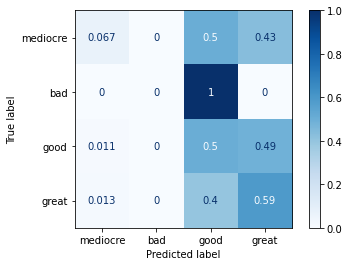

In [350]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
my_plot_confusion_matrix(knn, X, y)

### Decision Tree

/home/matheus/.miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



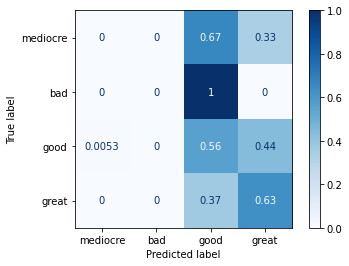

In [349]:
dt = DecisionTreeClassifier(max_depth=6)
my_plot_confusion_matrix(dt, X, y)

## Conclusions

The class imbalance posed a clear problem in the effectivity of the classification algorithms. This outcome was expected for the Decision Trees, as that is a widely know problem in the literature, but a similar result for the K-Nearest Neighbors algorithm came out as a surprise. Even after try outs of different k values, the classification for the lower represented classes still held bad results.

Although other approaches to feature engineering could be interesting to explore, directly dealing with the imbalance should be a better way of improving the quality of the models. Since the goal attribute `user_rating` is the result of the discretization of `user_score`, doing so in a way that it maintains the class balance or simply using `user_score` in a regression model should solve the problem.